In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from util import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from tqdm import tqdm
import torch_optimizer as optim

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Minimal preprocessing for validation
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# Minimal preprocessing for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [4]:
image_directory = "/home/ubuntu/isic-clinical-closeup"

In [5]:
class SimpleMLP(nn.Module):
    """
    Simple MLP model for clinical images only.
    Uses ResNet18 backbone to generate embeddings
    and passes them to an MLP for classification.
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # CNN backbone (ResNet18)
        convnext = models.convnext_tiny(pretrained=True)
        convnext.classifier = nn.Identity()
        self.backbone = convnext
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        # resnet.fc = nn.Identity()  # Remove classifier head
        # self.backbone = resnet
        
        # MLP on top of clinical embeddings
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)  # Binary classification
        )

    def forward(self, clinical):
        x = self.backbone(clinical)  # (B, 512)
        x = self.global_pool(x)           # [B, 768, 1, 1]
        x = x.view(x.size(0), -1)         # [B, 768]
        return self.classifier(x).squeeze(1)  # (B,)


In [6]:
excluded_base_names = [
    "s-prd-462542531.jpg",
    "s-prd-567681349.jpg",
    "s-prd-595361939.jpg",
    "s-prd-719354460.jpg",
    "s-prd-752575241.jpg",
    "s-prd-470472240.jpg",
    "s-prd-601218250.jpg",
    "s-prd-632469223.jpg",
    "s-prd-653536778.jpg",
    "s-prd-767507626.jpg"
]

def load_and_split_cropped_dataset(cropped_dirs, metadata_csv):
    """
    Args:
        cropped_dirs (list): List of directories containing cropped images.
        metadata_csv (str): Path to metadata CSV.
    Returns:
        train_df, val_df, test_df: DataFrames split from matched metadata.
    """
    df = pd.read_csv(metadata_csv)

    # Filter out control images
    df = df[df['midas_iscontrol'].str.lower() == 'no']

    # Normalize fields
    df['midas_distance'] = df['midas_distance'].str.lower()

    # Define modality
    df['modality'] = df['midas_distance'].apply(
        lambda x: 'dermoscope' if x == 'dscope' else ('clinical' if isinstance(x, str) else None)
    )

    # Filter to only 6in clinical images
    df = df[(df['modality'] == 'clinical') & (df['midas_distance'] == '6in')]

    # Assign label based on midas_path
    df['label'] = df['midas_path'].str.lower().str.contains("malig").astype(int)

    # Prepare for matching
    df['base_name'] = df['midas_file_name'].apply(lambda x: os.path.splitext(x)[0])
    metadata_lookup = df.set_index('base_name')

    metadata_lookup = metadata_lookup.drop(excluded_base_names, errors='ignore')

    # Match across all cropped directories
    matched_rows = []
    for cropped_dir in cropped_dirs:
        for f in os.listdir(cropped_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                base = os.path.splitext(f)[0]
                if base in metadata_lookup.index:
                    row = metadata_lookup.loc[base]
                    matched_rows.append({
                        'midas_record_id': row['midas_record_id'],
                        'clinical_path': os.path.join(cropped_dir, f),
                        'label': row['label'],
                        'clinical_midas_distance': row['midas_distance']
                    })

    matched_df = pd.DataFrame(matched_rows)

    # Split into train, val, test
    train_val, test_df = train_test_split(
        matched_df, test_size=0.15, random_state=42, stratify=matched_df["label"]
    )
    train_df, val_df = train_test_split(
        train_val, test_size=0.1765, random_state=42, stratify=train_val["label"]
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [8]:
image_directories_midas = ["/home/ubuntu/projects/melanoma-new/cropped_midas"]
metadata_csv_midas = "midas.csv"

train_df_midas, val_df_midas, test_df_midas = load_and_split_cropped_dataset(image_directories_midas, metadata_csv_midas)

train_dataset_midas = ClinicalSquareCropDataset(train_df_midas, image_directories_midas[0], transform=train_transform)
val_dataset_midas = ClinicalSquareCropDataset(val_df_midas, image_directories_midas[0], transform=val_transform)

train_loader_midas = DataLoader(train_dataset_midas, batch_size=32, shuffle=True)
val_loader_midas = DataLoader(val_dataset_midas, batch_size=32, shuffle=False)

In [9]:
model = SimpleMLP(dropout_rate=0)
state_dict = torch.load("pt_ckpts/model_isic_accuracy_epoch_1.pt", map_location=device)
model.load_state_dict(state_dict)
model.to(device)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SimpleMLP(
  (backbone): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,),

In [10]:
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

In [11]:
# --- Training Function ---
def train_one_epoch(loader):  # default
    model.train()
    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item():.4f}")


# --- Evaluation Function ---
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_logits, all_labels = [], []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits)
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")  # Handle single-class case

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)
    
    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc
    }


In [36]:
#### ADAPTIVE LEARNING RATE ####

# Freeze the backbone for initial training
for param in model.backbone.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for epoch in range(2):
    print(f"\nEpoch {epoch + 1}")
    train_one_epoch(train_loader_midas)
    train_metrics = evaluate(model, train_loader_midas)
    print(
        f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
        f"Accuracy = {train_metrics['accuracy']:.4f}, "
        f"Precision = {train_metrics['precision']:.4f}, "
        f"Recall = {train_metrics['recall']:.4f}, "
        f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
    )
    metrics = evaluate(model, val_loader_midas)
    print(
        f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
        f"Accuracy = {metrics['accuracy']:.4f}, "
        f"Precision = {metrics['precision']:.4f}, "
        f"Recall = {metrics['recall']:.4f}, "
        f"ROC-AUC = {metrics['roc_auc']:.4f}"
    )

# Unfreeze the backbone for fine-tuning
for param in model.backbone.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
initial_dropout = 0.0
regularized_dropout = 0.5
dropout_start_epoch = 0
weight_decay_start_epoch = 0

for epoch in range(25):
    print(f"\nEpoch {epoch + 1}")
    model.train()
    if epoch == dropout_start_epoch:
        print(f"Enabling dropout {regularized_dropout}")
        # Assuming dropout is the third layer in classifier (change accordingly)
        if hasattr(model, "classifier"):
            if isinstance(model.classifier[2], torch.nn.Dropout):
                model.classifier[2].p = regularized_dropout

    if epoch == weight_decay_start_epoch:
        print(f"Enabling weight decay 1e-5 and recreating optimizer")
        # Create new optimizer with weight decay, reusing current lr
        lr = optimizer.param_groups[0]['lr']
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler.optimizer = optimizer  # Update scheduler's optimizer reference

    # Training loop code here
    train_one_epoch(train_loader_midas)

    train_metrics = evaluate(model, train_loader_midas)
    print(
        f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
        f"Accuracy = {train_metrics['accuracy']:.4f}, "
        f"Precision = {train_metrics['precision']:.4f}, "
        f"Recall = {train_metrics['recall']:.4f}, "
        f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
    )
    
    metrics = evaluate(model, val_loader_midas)
    print(
        f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
        f"Accuracy = {metrics['accuracy']:.4f}, "
        f"Precision = {metrics['precision']:.4f}, "
        f"Recall = {metrics['recall']:.4f}, "
        f"ROC-AUC = {metrics['roc_auc']:.4f}"
    )
    val_loss = metrics['loss']

    # Save the model
    save_path = f"pt_ckpts/6-4-ckpts/model_epoch_{epoch}.pt"
    torch.save(model.state_dict(), save_path)
    print("Saved model to", save_path)
    
    # Step LR scheduler based on val loss
    scheduler.step(val_loss)

    


Epoch 1
Loss: 1.6423
Loss: 1.0052
Loss: 1.6261
Loss: 1.4420
Loss: 1.1477
Loss: 0.9836
Loss: 0.9529
Loss: 1.0232
Loss: 0.8252
Loss: 0.9525
Loss: 0.7818
Loss: 0.8508
Loss: 0.8667
Loss: 0.2966
Train Metrics: Loss = 0.8186, Accuracy = 0.6062, Precision = 0.4982, Recall = 0.8537, ROC-AUC = 0.7036
Validation Metrics: Loss = 0.8454, Accuracy = 0.5604, Precision = 0.4697, Recall = 0.8611, ROC-AUC = 0.6879

Epoch 2
Loss: 0.9376
Loss: 0.9336
Loss: 0.7257
Loss: 0.6858
Loss: 0.6219
Loss: 0.6774
Loss: 0.6505
Loss: 0.7163
Loss: 0.8444
Loss: 0.6136
Loss: 0.7258
Loss: 0.5232
Loss: 0.6126
Loss: 1.0241
Train Metrics: Loss = 0.6160, Accuracy = 0.6683, Precision = 0.5776, Recall = 0.5671, ROC-AUC = 0.7050
Validation Metrics: Loss = 0.6092, Accuracy = 0.6703, Precision = 0.5750, Recall = 0.6389, ROC-AUC = 0.7091

Epoch 1
Enabling dropout 0.5
Enabling weight decay 1e-5 and recreating optimizer
Loss: 0.5757
Loss: 0.5979
Loss: 0.6228
Loss: 0.5863
Loss: 0.5463
Loss: 0.6729
Loss: 0.6369
Loss: 0.6353
Loss: 0.52

In [13]:
for epoch in range(11):
    save_path = f"pt_ckpts/6-4-ckpts-transforms/model_epoch_{epoch}.pt"
    model = SimpleMLP(dropout_rate=0.5)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    model.eval()

    metrics = evaluate(model, val_loader_midas)
    print(
        f"save_path: {save_path},"
        f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
        f"Accuracy = {metrics['accuracy']:.4f}, "
        f"Precision = {metrics['precision']:.4f}, "
        f"Recall = {metrics['recall']:.4f}, "
        f"ROC-AUC = {metrics['roc_auc']:.4f}"
    )

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_0.pt,Validation Metrics: Loss = 0.5753, Accuracy = 0.7033, Precision = 0.6286, Recall = 0.6111, ROC-AUC = 0.7662


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_1.pt,Validation Metrics: Loss = 0.6165, Accuracy = 0.6264, Precision = 0.5172, Recall = 0.8333, ROC-AUC = 0.7561


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_2.pt,Validation Metrics: Loss = 0.5383, Accuracy = 0.7473, Precision = 0.6970, Recall = 0.6389, ROC-AUC = 0.8217


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_3.pt,Validation Metrics: Loss = 0.5986, Accuracy = 0.7033, Precision = 0.5849, Recall = 0.8611, ROC-AUC = 0.8116


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_4.pt,Validation Metrics: Loss = 0.5832, Accuracy = 0.7033, Precision = 0.5818, Recall = 0.8889, ROC-AUC = 0.8136


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_5.pt,Validation Metrics: Loss = 0.5272, Accuracy = 0.7912, Precision = 0.6977, Recall = 0.8333, ROC-AUC = 0.8465


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_6.pt,Validation Metrics: Loss = 0.4889, Accuracy = 0.8022, Precision = 0.7812, Recall = 0.6944, ROC-AUC = 0.8687


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_7.pt,Validation Metrics: Loss = 0.4686, Accuracy = 0.8571, Precision = 0.8108, Recall = 0.8333, ROC-AUC = 0.8970


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_8.pt,Validation Metrics: Loss = 0.8560, Accuracy = 0.7473, Precision = 0.6182, Recall = 0.9444, ROC-AUC = 0.8747


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_9.pt,Validation Metrics: Loss = 0.9491, Accuracy = 0.7912, Precision = 0.8148, Recall = 0.6111, ROC-AUC = 0.8318


/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


save_path: pt_ckpts/6-4-ckpts-transforms/model_epoch_10.pt,Validation Metrics: Loss = 0.7374, Accuracy = 0.7033, Precision = 0.8462, Recall = 0.3056, ROC-AUC = 0.8490


In [ ]:
save_path = f"pt_ckpts/6-4-ckpts-transforms/model_epoch_{7}.pt"
model = SimpleMLP(dropout_rate=0.5)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

metrics = evaluate(model, val_loader_midas)
print(f"Loaded model from {save_path}")
print(
    f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
    f"Accuracy = {metrics['accuracy']:.4f}, "
    f"Precision = {metrics['precision']:.4f}, "
    f"Recall = {metrics['recall']:.4f}, "
    f"ROC-AUC = {metrics['roc_auc']:.4f}"
)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-5)
for epoch in range(10):
    print(f"\nEpoch {epoch + 1}")
    train_one_epoch(train_loader_midas)
    train_metrics = evaluate(model, train_loader_midas)
    print(
        f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
        f"Accuracy = {train_metrics['accuracy']:.4f}, "
        f"Precision = {train_metrics['precision']:.4f}, "
        f"Recall = {train_metrics['recall']:.4f}, "
        f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
    )
    metrics = evaluate(model, val_loader_midas)
    print(
        f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
        f"Accuracy = {metrics['accuracy']:.4f}, "
        f"Precision = {metrics['precision']:.4f}, "
        f"Recall = {metrics['recall']:.4f}, "
        f"ROC-AUC = {metrics['roc_auc']:.4f}"
    )
    # Save the final model
    save_path = f"pt_ckpts/6-4-final-adjustments/final_model_epoch_{epoch}.pt"
    torch.save(model.state_dict(), save_path)


In [25]:
# Final evaluation on the test set
test_dataset_midas = ClinicalSquareCropDataset(test_df_midas, image_directories_midas[0], transform=val_transform)
test_loader_midas = DataLoader(test_dataset_midas, batch_size=32, shuffle=False)

In [28]:
save_path = f"pt_ckpts/6-4-final-adjustments/final_model_epoch_0.pt"
model = SimpleMLP(dropout_rate=0.5)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

metrics = evaluate(model, test_loader_midas)
print(f"FINAL MODEL METRICS (TEST)")
print(
    f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
    f"Accuracy = {metrics['accuracy']:.4f}, "
    f"Precision = {metrics['precision']:.4f}, "
    f"Recall = {metrics['recall']:.4f}, "
    f"ROC-AUC = {metrics['roc_auc']:.4f}"
)

/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FINAL MODEL METRICS (TEST)
Validation Metrics: Loss = 0.8875, Accuracy = 0.7111, Precision = 0.6364, Recall = 0.6000, ROC-AUC = 0.7808


In [29]:
@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    all_logits, all_labels = [], []
    all_images = []

    for batch in loader:
        clinical = batch["clinical"].to(device)
        labels = batch["label"].float().to(device)

        logits = model(clinical)

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_images.extend(clinical.cpu())  # Save images for visualization

    all_logits = torch.cat(all_logits)
    all_labels = torch.cat(all_labels)

    probs = torch.sigmoid(all_logits).squeeze()
    preds = (probs > 0.5).int()

    accuracy = accuracy_score(all_labels, preds)
    try:
        roc_auc = roc_auc_score(all_labels, probs)
    except:
        roc_auc = float("nan")

    try:
        precision = precision_score(all_labels, preds, zero_division=0)
        recall = recall_score(all_labels, preds, zero_division=0)
    except:
        precision = float("nan")
        recall = float("nan")

    loss = F.binary_cross_entropy(probs, all_labels)

    return {
        "loss": loss.item(),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "preds": preds.tolist(),
        "labels": all_labels.int().tolist(),
        "images": all_images,  # List of image tensors
        "probs": probs.tolist()
    }



def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def show_predictions(results, max_images=25, class_names=("Benign", "Malignant")):
    preds = results["preds"]
    labels = results["labels"]
    images = results["images"]
    probs = results["probs"]

    n = min(len(images), max_images)
    cols = 5
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for i in range(n):
        img = images[i]
        pred = preds[i]
        label = labels[i]
        prob = probs[i]

        # Proper de-normalization
        img = denormalize(img).clamp(0, 1)
        img = TF.to_pil_image(img)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis("off")

        correct = pred == label
        color = "green" if correct else "red"
        title = f"Pred: {class_names[pred]} ({prob:.2f})\nTrue: {class_names[label]}"
        plt.title(title, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


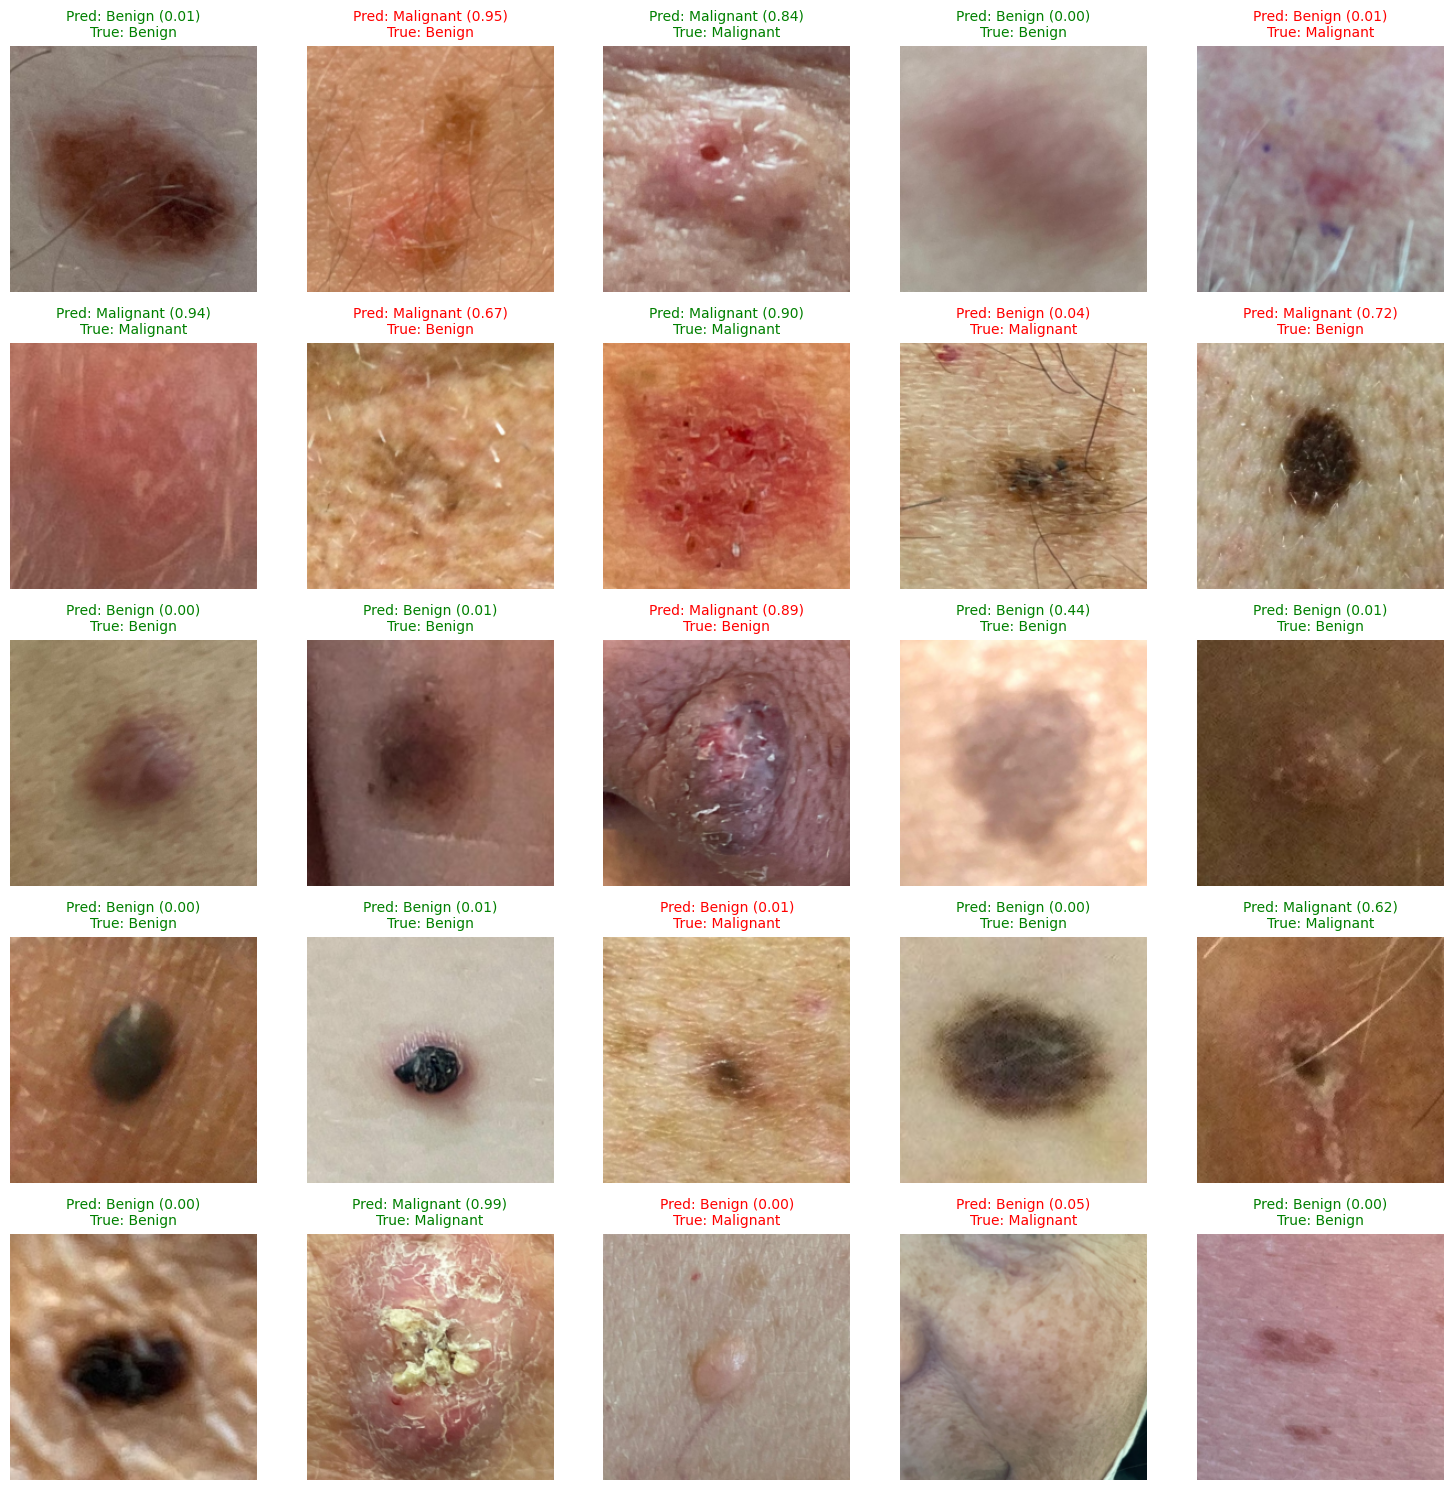

In [30]:
results = evaluate_with_preds(model, test_loader_midas)
show_predictions(results)


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(preds, labels, class_names=("Benign", "Malignant")):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()


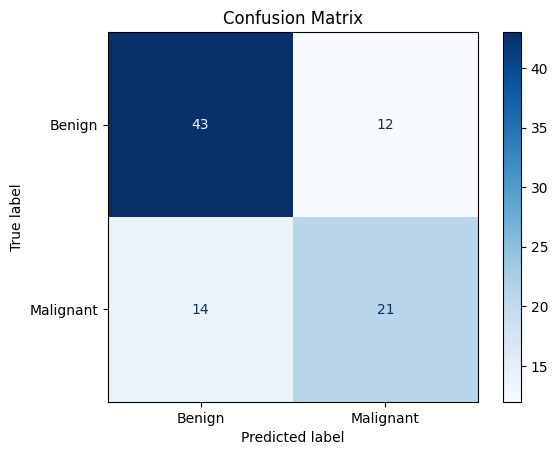

In [31]:
plot_confusion_matrix(results["preds"], results["labels"])

In [32]:
from sklearn.model_selection import StratifiedKFold


In [33]:
def generate_kfold_csv(cropped_dirs, metadata_csv, output_csv="kfold_midas.csv", n_splits=5, random_state=42):
    excluded_base_names = [
        "s-prd-462542531.jpg",
        "s-prd-567681349.jpg",
        "s-prd-595361939.jpg",
        "s-prd-719354460.jpg",
        "s-prd-752575241.jpg",
        "s-prd-470472240.jpg",
        "s-prd-601218250.jpg",
        "s-prd-632469223.jpg",
        "s-prd-653536778.jpg",
        "s-prd-767507626.jpg"
    ]

    df = pd.read_csv(metadata_csv)
    df = df[df['midas_iscontrol'].str.lower() == 'no']
    df['midas_distance'] = df['midas_distance'].str.lower()
    df['modality'] = df['midas_distance'].apply(
        lambda x: 'dermoscope' if x == 'dscope' else ('clinical' if isinstance(x, str) else None)
    )
    df = df[(df['modality'] == 'clinical') & (df['midas_distance'] == '6in')]
    df['label'] = df['midas_path'].str.lower().str.contains("malig").astype(int)
    df['base_name'] = df['midas_file_name'].apply(lambda x: os.path.splitext(x)[0])
    metadata_lookup = df.set_index('base_name')
    metadata_lookup = metadata_lookup.drop(excluded_base_names, errors='ignore')

    matched_rows = []
    for cropped_dir in cropped_dirs:
        for f in os.listdir(cropped_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                base = os.path.splitext(f)[0]
                if base in metadata_lookup.index:
                    row = metadata_lookup.loc[base]
                    matched_rows.append({
                        'midas_record_id': row['midas_record_id'],
                        'clinical_path': os.path.join(cropped_dir, f),
                        'label': row['label'],
                        'clinical_midas_distance': row['midas_distance'],
                        'base_name': base
                    })

    matched_df = pd.DataFrame(matched_rows).reset_index(drop=True)

    # Assign K-Fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    matched_df['fold'] = -1
    for fold_idx, (_, val_idx) in enumerate(skf.split(matched_df, matched_df["label"])):
        matched_df.loc[val_idx, "fold"] = fold_idx

    matched_df.to_csv(output_csv, index=False)
    print(f"Saved K-Fold split CSV to {output_csv}")

    return matched_df


In [35]:
image_directories_midas = ["/home/ubuntu/cropped_midas"]
metadata_csv_midas = "midas.csv"

df = generate_kfold_csv(image_directories_midas, metadata_csv_midas)

Saved K-Fold split CSV to kfold_midas.csv


In [36]:
df

,midas_record_id,clinical_path,label,clinical_midas_distance,base_name,fold
0,780,/home/ubuntu/cropped_midas/s-prd-792965911.jpg,0,6in,s-prd-792965911,2
1,117,/home/ubuntu/cropped_midas/s-prd-465588689.jpg,0,6in,s-prd-465588689,0
2,470,/home/ubuntu/cropped_midas/s-prd-647708242.jpg,1,6in,s-prd-647708242,4
3,378,/home/ubuntu/cropped_midas/s-prd-606643360.jpg,0,6in,s-prd-606643360,0
4,105,/home/ubuntu/cropped_midas/s-prd-462526905.jpg,0,6in,s-prd-462526905,4
...,...,...,...,...,...,...
595,41,/home/ubuntu/cropped_midas/s-prd-418876279.jpg,1,6in,s-prd-418876279,0
596,428,/home/ubuntu/cropped_midas/s-prd-635950116.jpg,1,6in,s-prd-635950116,3
597,248,/home/ubuntu/cropped_midas/s-prd-522456716.jpg,0,6in,s-prd-522456716,4
598,167,/home/ubuntu/cropped_midas/s-prd-489108911.jpg,1,6in,s-prd-489108911,0


In [ ]:
all_fold_metrics = []
for fold in range(5):
    print(f"Running Fold {fold}")
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]
    # Train your model here
    
    train_dataset_midas = ClinicalSquareCropDataset(train_df_midas, image_directories_midas[0], transform=train_transform)
    val_dataset_midas = ClinicalSquareCropDataset(val_df_midas, image_directories_midas[0], transform=val_transform)

    train_loader_midas = DataLoader(train_dataset_midas, batch_size=32, shuffle=True)
    val_loader_midas = DataLoader(val_dataset_midas, batch_size=32, shuffle=False)

    model = SimpleMLP(dropout_rate=0)
    state_dict = torch.load("pt_ckpts/model_isic_accuracy_epoch_1.pt", map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    
    # Freeze the backbone for initial training
    for param in model.backbone.parameters():
        param.requires_grad = False
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(2):
        print(f"\nEpoch {epoch + 1}")
        train_one_epoch(train_loader_midas)
        train_metrics = evaluate(model, train_loader_midas)
        print(
            f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
            f"Accuracy = {train_metrics['accuracy']:.4f}, "
            f"Precision = {train_metrics['precision']:.4f}, "
            f"Recall = {train_metrics['recall']:.4f}, "
            f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
        )
        metrics = evaluate(model, val_loader_midas)
        print(
            f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
            f"Accuracy = {metrics['accuracy']:.4f}, "
            f"Precision = {metrics['precision']:.4f}, "
            f"Recall = {metrics['recall']:.4f}, "
            f"ROC-AUC = {metrics['roc_auc']:.4f}"
        )

    # Unfreeze the backbone for fine-tuning
    for param in model.backbone.parameters():
        param.requires_grad = True

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    initial_dropout = 0.0
    regularized_dropout = 0.5
    dropout_start_epoch = 0
    weight_decay_start_epoch = 0

    for epoch in range(10):
        print(f"\nEpoch {epoch + 1}")
        model.train()
        if epoch == dropout_start_epoch:
            print(f"Enabling dropout {regularized_dropout}")
            # Assuming dropout is the third layer in classifier (change accordingly)
            if hasattr(model, "classifier"):
                if isinstance(model.classifier[2], torch.nn.Dropout):
                    model.classifier[2].p = regularized_dropout

        if epoch == weight_decay_start_epoch:
            print(f"Enabling weight decay 1e-5 and recreating optimizer")
            # Create new optimizer with weight decay, reusing current lr
            lr = optimizer.param_groups[0]['lr']
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
            scheduler.optimizer = optimizer  # Update scheduler's optimizer reference

        # Training loop code here
        train_one_epoch(train_loader_midas)

        train_metrics = evaluate(model, train_loader_midas)
        print(
            f"Train Metrics: Loss = {train_metrics['loss']:.4f}, "
            f"Accuracy = {train_metrics['accuracy']:.4f}, "
            f"Precision = {train_metrics['precision']:.4f}, "
            f"Recall = {train_metrics['recall']:.4f}, "
            f"ROC-AUC = {train_metrics['roc_auc']:.4f}"
        )
        
        metrics = evaluate(model, val_loader_midas)
        print(
            f"Validation Metrics: Loss = {metrics['loss']:.4f}, "
            f"Accuracy = {metrics['accuracy']:.4f}, "
            f"Precision = {metrics['precision']:.4f}, "
            f"Recall = {metrics['recall']:.4f}, "
            f"ROC-AUC = {metrics['roc_auc']:.4f}"
        )
        val_loss = metrics['loss']

        # Save the model
        save_path = f"pt_ckpts/6-4-ckpts/model_epoch_{epoch}.pt"
        # torch.save(model.state_dict(), save_path)
        print("Saved model to", save_path)
        
        # Step LR scheduler based on val loss
        scheduler.step(val_loss)